# <font color = white > **Stochastic Simulation (5284STSI6Y) | MSc Computational Science at UvA** </font>

# <font color = #DE3163 > **Assignment 1: Mandelbrot Set** </font>
*By Victor Piaskowski(15132625), Sanjhana Bhusal (14724383), and Lisa Pahladsingh(13846566)*

Link to Github Repository: https://github.com/BiggusVickus/Stochastic_Simulation

In [1]:
# Standard library imports
import time
time_start = time.time()
from statistics import mean, stdev, variance 
import warnings

# Related third party imports
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorsys
import random
import time
import scipy.stats as stats
import math
from numba import jit

warnings.simplefilter("ignore")

## <font color = LightCoral> **Visual Representation of the Mandelbrot Set** </font>

In [2]:
# Constants
image_width = 1000  
x_center = -0.65  
y_center = 0  
x_range = 3.4 
aspect_ratio = 4/3  

precision = 500  # Number of iterations to determine if a point is in the Mandelbrot set

# Derived constants
image_height = round(image_width / aspect_ratio)  
y_range = x_range / aspect_ratio  
min_x = x_center - x_range / 2  
max_x = x_center + x_range / 2
min_y = y_center - y_range / 2
max_y = y_center + y_range / 2

# Defining color scheme of the fractal
def power_color(distance, exp, const, scale):
    """
    Generates a color based on the distance to the set.
    
    Args:
        distance (float): Normalized iteration count.
        exp (float): Exponent for scaling the distance.
        const (float): Constant factor for hue.
        scale (float): Scale factor for hue.

    Returns:
        tuple: RGB color.
    """
    color = distance**exp
    rgb = colorsys.hsv_to_rgb(const + scale * color, 1 - 0.6 * color, 0.9)
    return tuple(round(i * 255) for i in rgb)

# Generating Mandelbrot
def generate_fractal(width, height, min_x, max_x, min_y, max_y, precision):
    """
    Generates and saves an image of the Mandelbrot set.

    Args:
        width (int): Width of the image.
        height (int): Height of the image.
        min_x (float): Minimum x-value.
        max_x (float): Maximum x-value.
        min_y (float): Minimum y-value.
        max_y (float): Maximum y-value.
        precision (int): Iteration count for the Mandelbrot set calculation.

    Returns:
        None: The image is saved directly to a file.
    """
    img = Image.new('RGB', (width, height), color='black')
    pixels = img.load()
    
    for row in range(height):
        for col in range(width):
            x = min_x + col * (max_x - min_x) / width
            y = max_y - row * (max_y - min_y) / height
            old_x, old_y = x, y
            for i in range(precision + 1):
                a = x*x - y*y  # Real component of z^2
                b = 2 * x * y  # Imaginary component of z^2
                x = a + old_x  # Real component of new z
                y = b + old_y  # Imaginary component of new z
                if x*x + y*y > 4:  # Check if the point escapes the Mandelbrot set
                    break
            if i < precision:
                distance = (i + 1) / (precision + 1)
                rgb = power_color(distance, 0.2, 0.35, 1.0)
                pixels[col, row] = rgb

    img.save('output.png')  # Save the generated image

# Visualise the fractal image
generate_fractal(image_width, image_height, min_x, max_x, min_y, max_y, precision)


## <font color = LightCoral> **Different Sampling Methods** </font>

In [3]:
def random_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples, antithetic=False):
    """randomly creates points within the mandelbrot set to be tested

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image
        samples (int): number of samples to take

    Returns:
        list: returns list cosnisting of random x and y points, and the same points scaled to the image dimensions to be plotted on the mandelbrot set image
    """
    
    # Lists for random points in the complex plane and the same points scaled to the image dimensions
    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    iteration = 0
    while (iteration < samples):
        # Random real and complex points
        random_x = random.uniform(xmin, xmax)
        random_y = random.uniform(ymin, ymax)
        if not antithetic:

            # U distribution, non antithetic version
            # Append random value to list
            random_x_axis.append(random_x)
            random_y_axis.append(random_y)

            random_x_axis_plotted.append((random_x + abs(xmin)) * pixeldensity)
            random_y_axis_plotted.append((random_y + abs(ymin)) * pixeldensity)
            iteration += 1

        else:
            # 1- U distribution, antithetic version 
            random_x = (xmin + xmax) - random_x
            random_y = (ymin + ymax) - random_y

            random_x_axis.append(random_x)
            random_y_axis.append(random_y)
            random_x_axis_plotted.append((random_x + abs(xmin)) * pixeldensity)
            random_y_axis_plotted.append((random_y + abs(ymin)) * pixeldensity)
            iteration += 1
            
    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted

def latin_hypercube_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):
    """creates a grid of samples*samples size grid and randomly samples from each row and column to create a latin hypercube

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image 
        samples (int): number of samples to take, namely how large the grid will be

    Returns:
        list: returns 4 lists of equal size, the x and y points of the randomly selected latin hypercube points and the x and y points of the latin hypercube scaled to the image dimensions
    """
    # Create starting points for the grid in real, complex direction
    x_points = np.linspace(xmin, xmax, samples+1)
    y_points = np.linspace(ymin, ymax, samples+1)

    # Bin size of the dots to randomly choose a point inside the bin position
    bin_size = x_points[1] - x_points[0]

    random_x_axis = []
    random_y_axis = []
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    while (y_points.shape[0] != 0):
        # Randomly choose a bin and a point inside the bin, add the values together to get the random point for both real and complex to ensure that there is one point inside the bin
        random_x = random.randint(0, x_points.shape[0]-1)
        random_x_bin = random.uniform(0, bin_size)
        random_x_axis.append(x_points[random_x] + random_x_bin)

        random_y = random.randint(0, y_points.shape[0]-1)
        random_y_bin = random.uniform(0, bin_size)
        random_y_axis.append(y_points[random_y] + random_y_bin)

        # Convert to plotting space
        random_x_axis_plotted.append((x_points[random_x] + random_x_bin + abs(xmin))*pixeldensity)
        random_y_axis_plotted.append((y_points[random_y] + random_y_bin + abs(ymin))*pixeldensity)

        # Delete the row and column that the point was chosen from to ensure that there is only one point per row and column
        x_points = np.delete(x_points, random_x)
        y_points = np.delete(y_points, random_y)
    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted


def orthogonal_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples):
    """ Divides the sample space into a grid of equally sized blocks
        and selects a random point from each block, ensuring no two points are in the same
        row or column. 

        Args:
            xmin (float): Minimum value of x-axis for the Mandelbrot set.
            xmax (float): Maximum value of x-axis for the Mandelbrot set.
            ymin (float): Minimum value of y-axis for the Mandelbrot set.
            ymax (float): Maximum value of y-axis for the Mandelbrot set.
            pixeldensity (int): Number of pixels for the output image.
            samples (int): Number of samples to take, determining the grid size.

        Returns:
            list: Four lists of equal size containing the x and y points of the orthogonal
                sample and the x and y points scaled to the image dimensions.
        """
    # Number of rows/columns
    n_block_rc = np.sqrt(samples) 

    # Sample space width
    x_space = xmax - xmin
    y_space = ymax - ymin

    # Creating sample options grid locations
    x_samples = np.linspace(0, samples, samples)
    y_samples = np.linspace(0, samples, samples)

    # List for sampling
    random_x_axis = []
    random_y_axis = []

    # List for plotting
    random_x_axis_plotted = []
    random_y_axis_plotted = []

    for i in range(int(n_block_rc)):
        for j in range(int(n_block_rc)):
            x_min = i * n_block_rc
            x_max = (i + 1) * n_block_rc
            y_min = j * n_block_rc
            y_max = (j + 1) * n_block_rc

            # Get sublists
            x_sublist = x_samples[(x_samples >= x_min) & (x_samples <= x_max)]
            y_sublist = y_samples[(y_samples >= y_min) & (y_samples <= y_max)]

            # Get random x
            x_rand = np.random.choice(x_sublist)
            y_rand = np.random.choice(y_sublist)

            # Sample points
            x = xmin + (x_rand / samples) * x_space
            y = ymin + (y_rand / samples) * y_space

            # Convert to sample space
            random_x_axis.append(x)
            random_y_axis.append(y)

            # Converting to plotting space
            random_x_axis_plotted.append((x + abs(xmin))*pixeldensity)
            random_y_axis_plotted.append((y + abs(ymin))*pixeldensity)

            # Deleting values from list
            x_samples = np.delete(x_samples, np.where(x_samples == x_rand))
            y_samples = np.delete(y_samples, np.where(y_samples == y_rand))

    return random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted

## <font color = LightCoral > **Functions to Generate Mandelbrot** </font>

In [4]:
def complex_matrix(xmin, xmax, ymin, ymax, pixeldensity):
    """creates a complex matrix for the mandelbrot set to be plotted on with dimensions of pixeldensity*pixeldensity

    Args:
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image

    Returns:
        complex matrix: retuns a complex matrix of linearly spaced complex numbers
    """
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixeldensity))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixeldensity))
    return re[np.newaxis, :] + im[:, np.newaxis] * 1j 

@jit(nopython=True)
def is_stable(c, num_iterations):
    """calculates the stability of a point in the mandelbrot set by iterating z = z^2 + c num_iterations times and determining if the point is inside or outside the mandelbrot set

    Args:
        c (complex matrix): complex matrix to iterate over
        num_iterations (int): number of iterations to iterate over before deciding if the point is inside or outside the mandelbrot set

    Returns:
        matrix: matrix values consisiting of True if the point is inside the mandelbrot set and False if the point is outside the mandelbrot set
    """
    z = c  # Complex matrix c
    for n in range(num_iterations):
        if abs(z*z) > 4:  # Use abs2() for complex numbers
            return n      # Ff magnitude z > 2 --> point outside Mandelbrot
        z = z*z + c
    return num_iterations

@jit(nopython=True)
def point_inside(x_array, y_array, iterations):
    """determines if a list of points are either inside or outside the mandelbrot set

    Args:
        x_array (list): list of x coordinates of points to be tested
        y_array (list): list of y coordinates of points to be tested
        iterations (int): number of iterations to be done before testing to see if the point is inside or outside the mandelbrot set

    Returns:
        list: list of boolean values, true if the point is inside the mandelbrot set, false if the point is outside the mandelbrot set
    """
    truth_values = []  # Stores boolean values: 'True' if inside mandelbrot & 'False' if outside mandelbrot
    for i in range(0, len(x_array)):
        z_0 = 0
        c = complex(x_array[i], y_array[i])
        append=False
        for i in range(iterations):
            z_0 = z_0 * z_0 + c
            if abs(z_0) > 2:
                truth_values.append(False)  # If magnitude z > 2 --> point outside Mandelbrot
                append = True
                break
        if (append == False):
            truth_values.append(True)
    return truth_values

def calculate_i_s(stable_points, iterations, samples, numberruns, xmin, xmax, ymin, ymax, pixeldensity, typeof, printimage = False, saveimage = False):
    """runs a simulation to determine the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set after choosing a number of samples and iterations and type of testing

    Args:
        stable_points (complex matrix): complex matrix of mandelbrot set
        iterations (int): number of iterations to be done before testing to see if the point is inside or outside the mandelbrot set
        samples (int): number of samples to take
        numberruns (int): number of times to randomly select points and calculate the area of the mandelbrot set for a given number of iterations and samples
        xmin (float): min value of x axis for mandelbrot set
        xmax (float): max value of x axis for mandelbrot set
        ymin (float): min value of y axis for mandelbrot set
        ymax (float): max value of y axis for mandelbrot set
        pixeldensity (int): number of pixels for image
        typeof (string): type of algorithm to run, either "random" or "latin", in future orthogonal sampling will be added
        printimage (bool, optional): Determines if image of mandelbort image is printed in output for each iteration. Defaults to False.
        saveimage (bool, optional): Determines if image of mandelbort image is saved to hard disk for each iteration. Defaults to False.

    Returns:
        ratio, area: returns the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set
    """

    # Store the ratios of dots inside to outside the mandelbrot set as well as the estimated area of the mandelbrot set
    list_ratio_in_to_out = []
    list_estimated_area = []

    for i in range(0, numberruns):
        # Choose the algorithm type depending on users input. Run this for numberruns times
        if (typeof == "Random"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = random_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        elif (typeof == "Latin"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = latin_hypercube_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        elif (typeof == "Orthogonal"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = orthogonal_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples)
        elif (typeof == "Antithetic"):
            random_x_axis, random_y_axis, random_x_axis_plotted, random_y_axis_plotted = random_sampling(xmin, xmax, ymin, ymax, pixeldensity, samples, antithetic=True)
                
        else:
            print("Please enter a valid type of sampling")
            return
        # Determine if the randomly chosen points in the list are inside or outside the mandelbrot set
        inside_outside = point_inside(random_x_axis, random_y_axis, iterations)

        # Calcualte the ratio of points inside to outside the mandelbrot set and calcualte the estimated area of the mandelbrot set
        number_true = sum(inside_outside)
        ratio_in_to_out = number_true/samples
        estimated_area = ratio_in_to_out*(xmax-xmin)*(ymax-ymin)

        # Store the results
        list_ratio_in_to_out.append(ratio_in_to_out)
        list_estimated_area.append(estimated_area)
    
    # Calculate the mean and stdev of the ratio and estimated area of the mandelbrot set
    ratio_in_to_out = np.mean(list_ratio_in_to_out)
    estimated_area = np.mean(list_estimated_area)
    estimated_area_sd = stdev(list_estimated_area)
    
    if(saveimage or printimage):
        # If user wants the image printed in output, or saved to hard disk, plot the mandelbrot set and the randomly chosen points and print and/or save the image
        fig, ax1 = plt.subplots(1,1, dpi=300)
        plt.imshow(stable_points)
        ax1.scatter(random_x_axis_plotted, random_y_axis_plotted, c=inside_outside, s=1, cmap="coolwarm")
        plt.gca().set_aspect("equal")
        plt.xlabel("Real Axis")
        plt.ylabel("Imaginary Axis")
        ax1.set_title("Mandelbrot Set with {} Iterations and {} Samples. \n Estimated Area of Using the {} Algorithm is {} \n Run {} times (SD = {})".format(iterations, samples, typeof, round(estimated_area,3), numberruns, round(estimated_area_sd,3)))
        ax1.invert_yaxis()
        plt.tight_layout()
        plt.axis('off')

        if (saveimage):
            image_name =  typeof + '_' + str(iterations) + "_" + str(samples) + '_' + str(estimated_area) + ".png"
            plt.savefig("PlotImages/" + image_name, dpi=300)
            print("Image saved as: ", image_name)
        if (printimage):
            plt.show()
        plt.close()
    return ratio_in_to_out, estimated_area, estimated_area_sd, list_estimated_area


def run_simulation(numberiterations, numbersamples, typeof, stablecomplexmatrix, numberruns = 10, xmin=-2, xmax=0.5, ymin=-1, ymax=1, pixeldensity=1000, printimage = False, saveimage = False):
    """runs a simulation to determine the ratio of points inside to outside the mandelbrot set and the estimated area of the mandelbrot set after choosing a number of samples and iterations and type of testing

    Args:
        numberiterations (list): list of iterations to be done before testing to see if the point is inside or outside the mandelbrot set
        numbersamples (list): list of samples to take
        typeof (string): string of type of algorithm to run, either "random" or "latin", or "orthogonal"
        stablecomplexmatrix (complex matrix): complex matrix of mandelbrot set
        numberruns (int, optional): number of times to randomly select points and calculate the area of the mandelbrot set for a given number of iterations and samples. Defaults to 10.
        xmin (float, optional): min value of x axis for mandelbrot set. Defaults to -2.
        xmax (float, optional): max value of x axis for mandelbrot set. Defaults to 0.5.
        ymin (float, optional): min vlaue of y axis for mandelbrot set. Defaults to -1.
        ymax (float, optional): max vlaue of y axis for mandelbrot set. Defaults to 1.
        pixeldensity (int, optional): number of pixels for image. Defaults to 1000.
        printimage (bool, optional): choose if you want images to be printed to output cell. Defaults to False.
        saveimage (bool, optional): choose if you want image to be saved to hard drive. Defaults to False.
    """

    data_results = []
    plot_iterations = {}

    # Run the simulation for each number of iterations and number of samples
    for i in range(len(numberiterations)):
        area_list_iteration = []
        for j in range(len(numbersamples)):
            # Calculate the area and stdev of the points. Save the results in a list
            ratio, area, stdev, raw_area = calculate_i_s(stablecomplexmatrix, numberiterations[i], numbersamples[j], numberruns, xmin, xmax, ymin, ymax, pixeldensity, typeof, printimage, saveimage)
            data_results.append([numberiterations[i], numbersamples[j], ratio, area, stdev])
            area_list_iteration.append(area)

        plot_iterations[numberiterations[i]] = area_list_iteration

    return plot_iterations, data_results, raw_area

## <font color = LightCoral> **Generating Results** </font>

### <font color = Gray> ***Plots of the Area Estimation using different Monte Carlo Integration Methods***</font>

In [5]:
# Define complex matrix grid for image representation
c_matrix = complex_matrix(-2, 0.5, -1, 1, 1000)
mandelbrot_stability_vec = np.vectorize(is_stable)
c_matrix = mandelbrot_stability_vec(c_matrix, 1000)

In [6]:
# Define i, s, and number of runs 
number_iterations = [1000]
number_samples = [1000]
number_runs = 15

# Generate graphs of the different sampling methods with different iteration and sample sizes
plot_iterations = run_simulation(number_iterations, number_samples, "Random", c_matrix, numberruns = number_runs, printimage=False, saveimage = False)
plot_iterations = run_simulation(number_iterations, number_samples, "Latin", c_matrix, numberruns = number_runs, printimage=False, saveimage = False)
plot_iterations = run_simulation(number_iterations, number_samples, "Orthogonal", c_matrix, numberruns = number_runs, printimage=False, saveimage = False)

### <font color = Gray> ***Plots for Qualitative Analysis***</font>

#### <font color = Silver> ***Convergence of Estimated Area: Varying Iteration***</font>

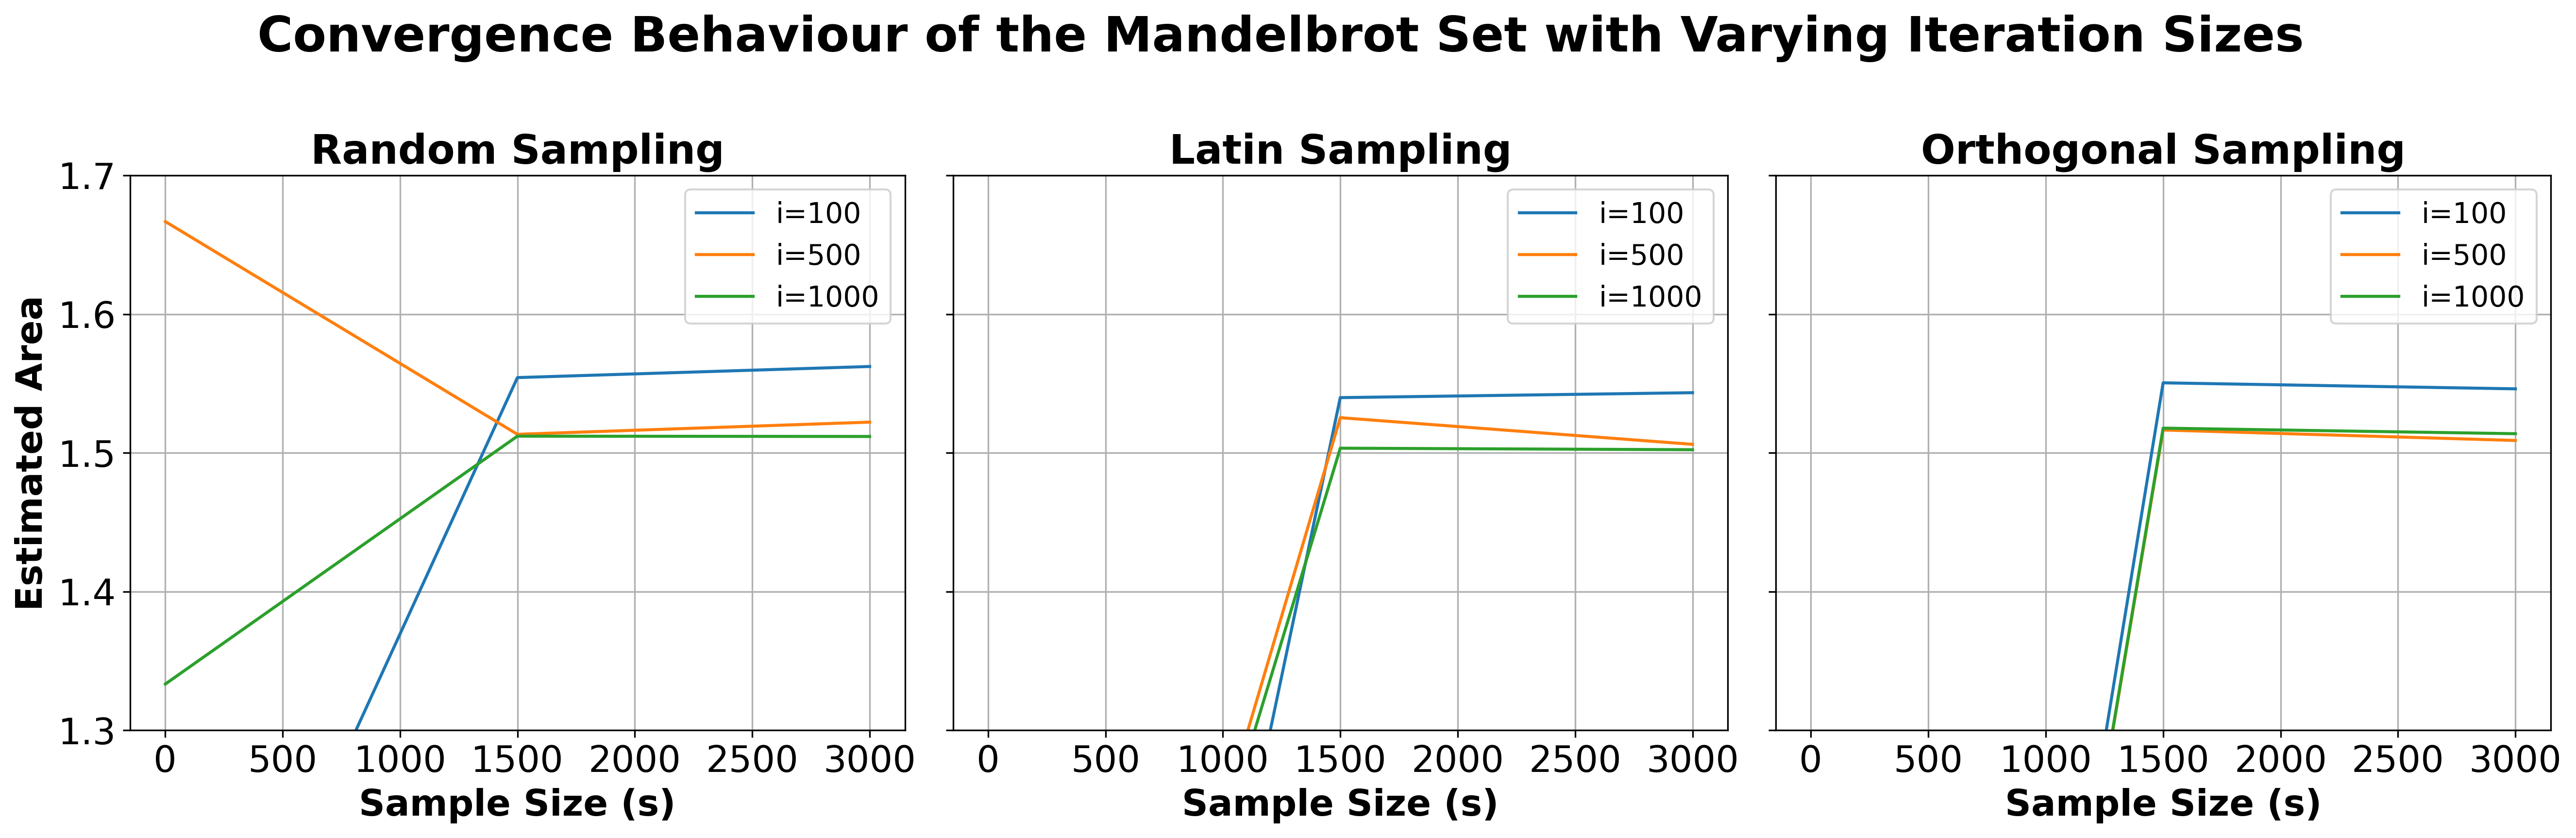

In [7]:
# This takes 1-5 min to compute so don't worry if it takes a while
# Define parameters
number_iterations = [100, 500, 1000]
number_samples = np.linspace(1, 3000, 3, dtype=int) # Change the 3 to 100 to generate results from report
number_runs = 15

# Function to extract and plot data
def plot_method_data(ax, method_name, c_matrix):
    """Generate convergence of mandelbrot set with increasing sample sizes and for varying iteration sizes

    Args:
        ax (axes): axes to draw on
        method_name (string): method name to run simulation on
        c_matrix (matrix): comples matrix with mandelbrot set
    """
    plot_iterations, data_results, _ = run_simulation(number_iterations, number_samples, method_name, c_matrix, numberruns=number_runs)
    for iteration in number_iterations:
        iter_data = [item for item in data_results if item[0] == iteration]
        sample_sizes = [item[1] for item in iter_data]
        mean_areas = [item[3] for item in iter_data]
        ax.plot(sample_sizes, mean_areas, label=f"i={iteration}")

# Initialize figure and axes
fig, axs = plt.subplots(1, 3, dpi=300, figsize=(18, 6), sharey=True)

# Plot for each method
sampling_methods = ["Random", "Latin", "Orthogonal"]
for ax, method in zip(axs, sampling_methods):
    plot_method_data(ax, method, c_matrix)
    ax.set_xlabel("Sample Size (s)", fontsize=18, fontweight='bold')
    ax.set_title(f"{method} Sampling", fontsize=20, fontweight='bold')
    ax.legend(loc='upper right', prop={"size":14})
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=18)

# Set the y-axis label on the leftmost subplot
axs[0].set_ylabel("Estimated Area", fontsize=18, fontweight='bold')
axs[0].set_ylim(1.3, 1.7)

# Add an overall title
plt.suptitle("Convergence Behaviour of the Mandelbrot Set with Varying Iteration Sizes", fontsize=24, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.show()

#### <font color = Silver> ***Convergence of Estimated Area: Varying Sample Sizes***</font>

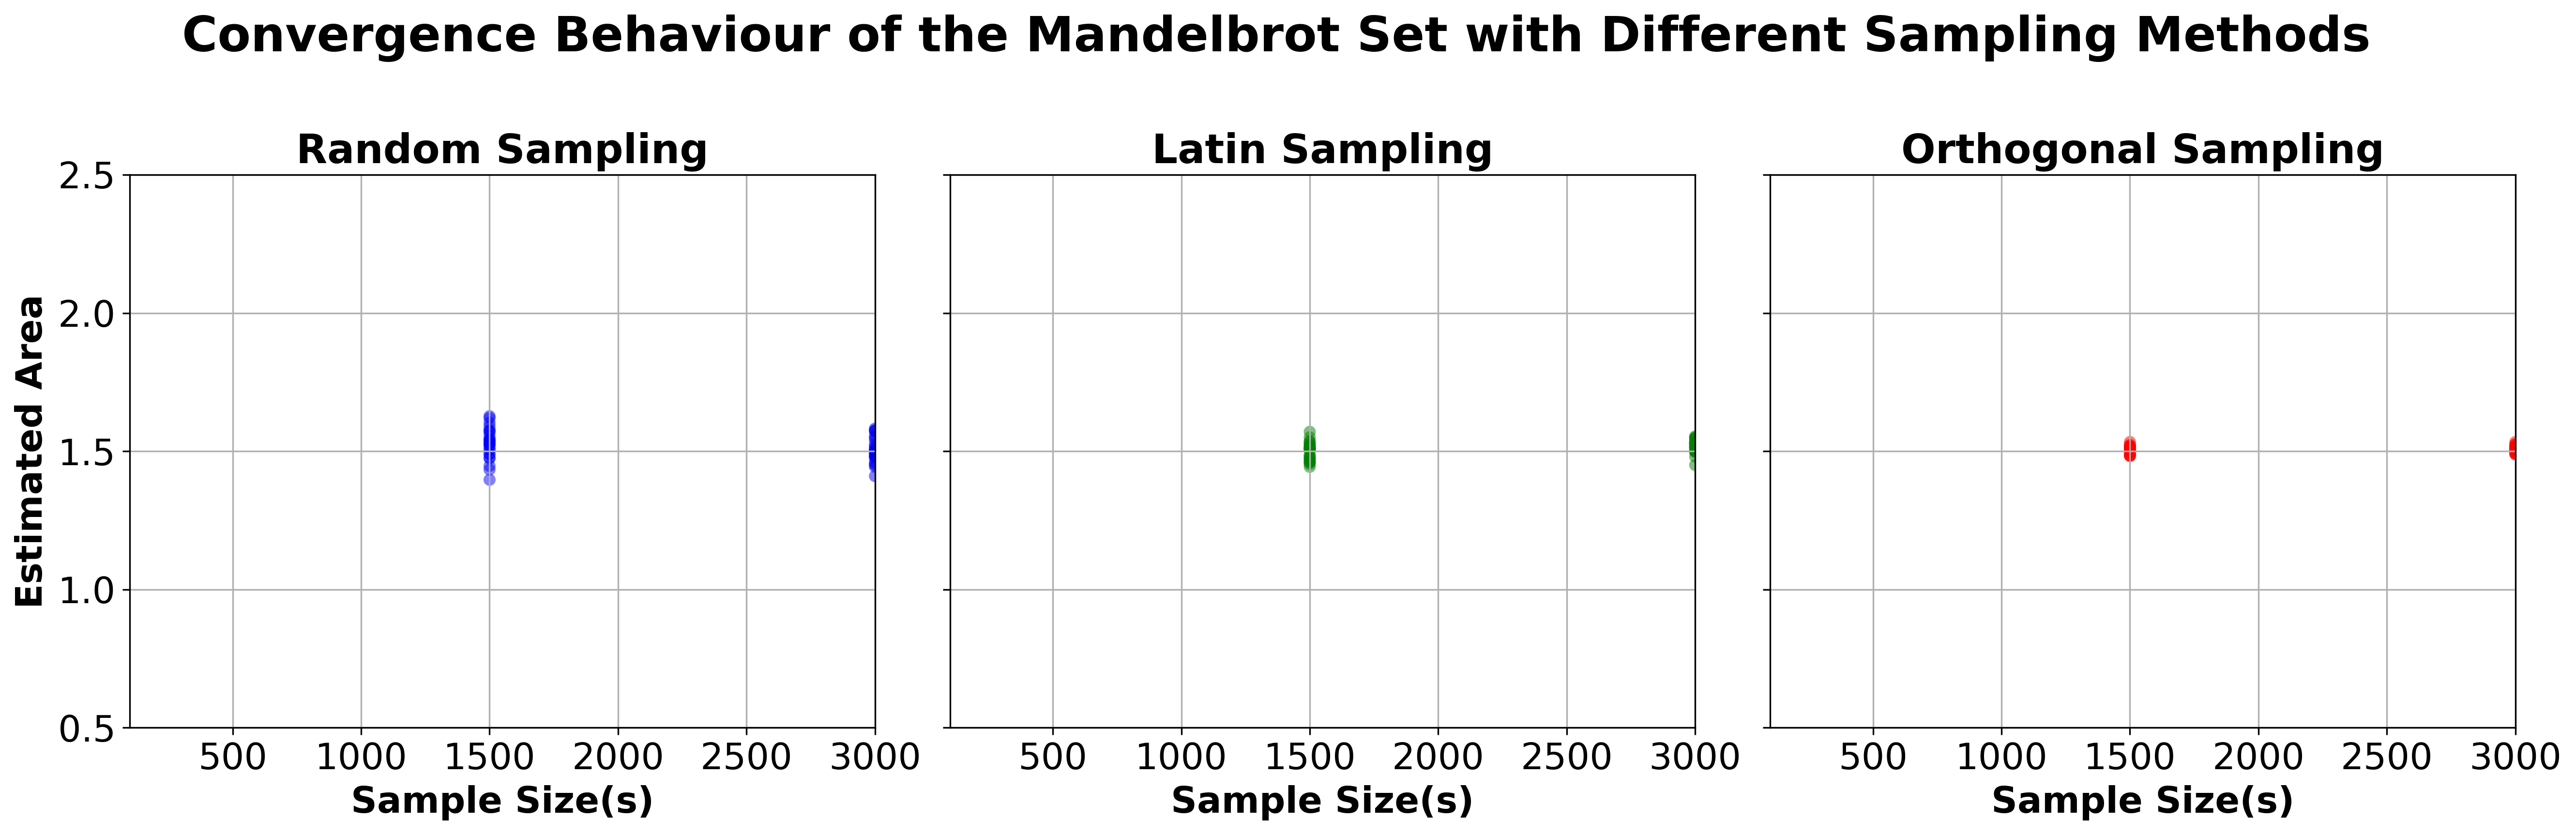

In [8]:
# This takes 1-5 min to compute so don't worry if it takes a while
# Define parameters
number_iterations = [1000]  # Fixed number of iterations
number_samples = np.linspace(1, 3000, 3, dtype=int) # Change the 3 to 100 to generate results from report
number_runs = 25

# Initialize the figure with 1 row and 3 columns for subplots
fig, axs = plt.subplots(1, 3, dpi=300, figsize=(18, 6), sharey=True)

# Define the sampling methods
sampling_methods = ["Random", "Latin", "Orthogonal"]
colors = ["blue", "green", "red"]

# Loop over each sampling method and create its subplot
for ax, method, color in zip(axs, sampling_methods, colors):
    for samples in number_samples:
        # Run the simulation and get the areas
        _, _, areas = run_simulation(number_iterations, [samples], method, c_matrix, numberruns=number_runs)
        
        # Plot each area value for the current sample size
        ax.scatter([samples] * len(areas), areas, alpha=0.5, edgecolors='none', color=color)
    
    ax.set_xlabel("Sample Size(s)", fontsize=18, fontweight='bold')
    ax.set_xlim(100, max(number_samples)) 
    ax.set_title(f"{method} Sampling", fontsize=20, fontweight='bold')
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=18)

# Set the y-axis label on the leftmost subplot
axs[0].set_ylabel("Estimated Area", fontsize=18, fontweight='bold')
axs[0].set_ylim(0.5, 2.5)

# Add an overall title and adjust layout
plt.suptitle("Convergence Behaviour of the Mandelbrot Set with Different Sampling Methods", fontsize=24, fontweight="bold")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

# Display the plots
plt.show()


#### <font color = Silver> ***Maximum Difference Estimated Area: Varying Sample Sizes***</font>

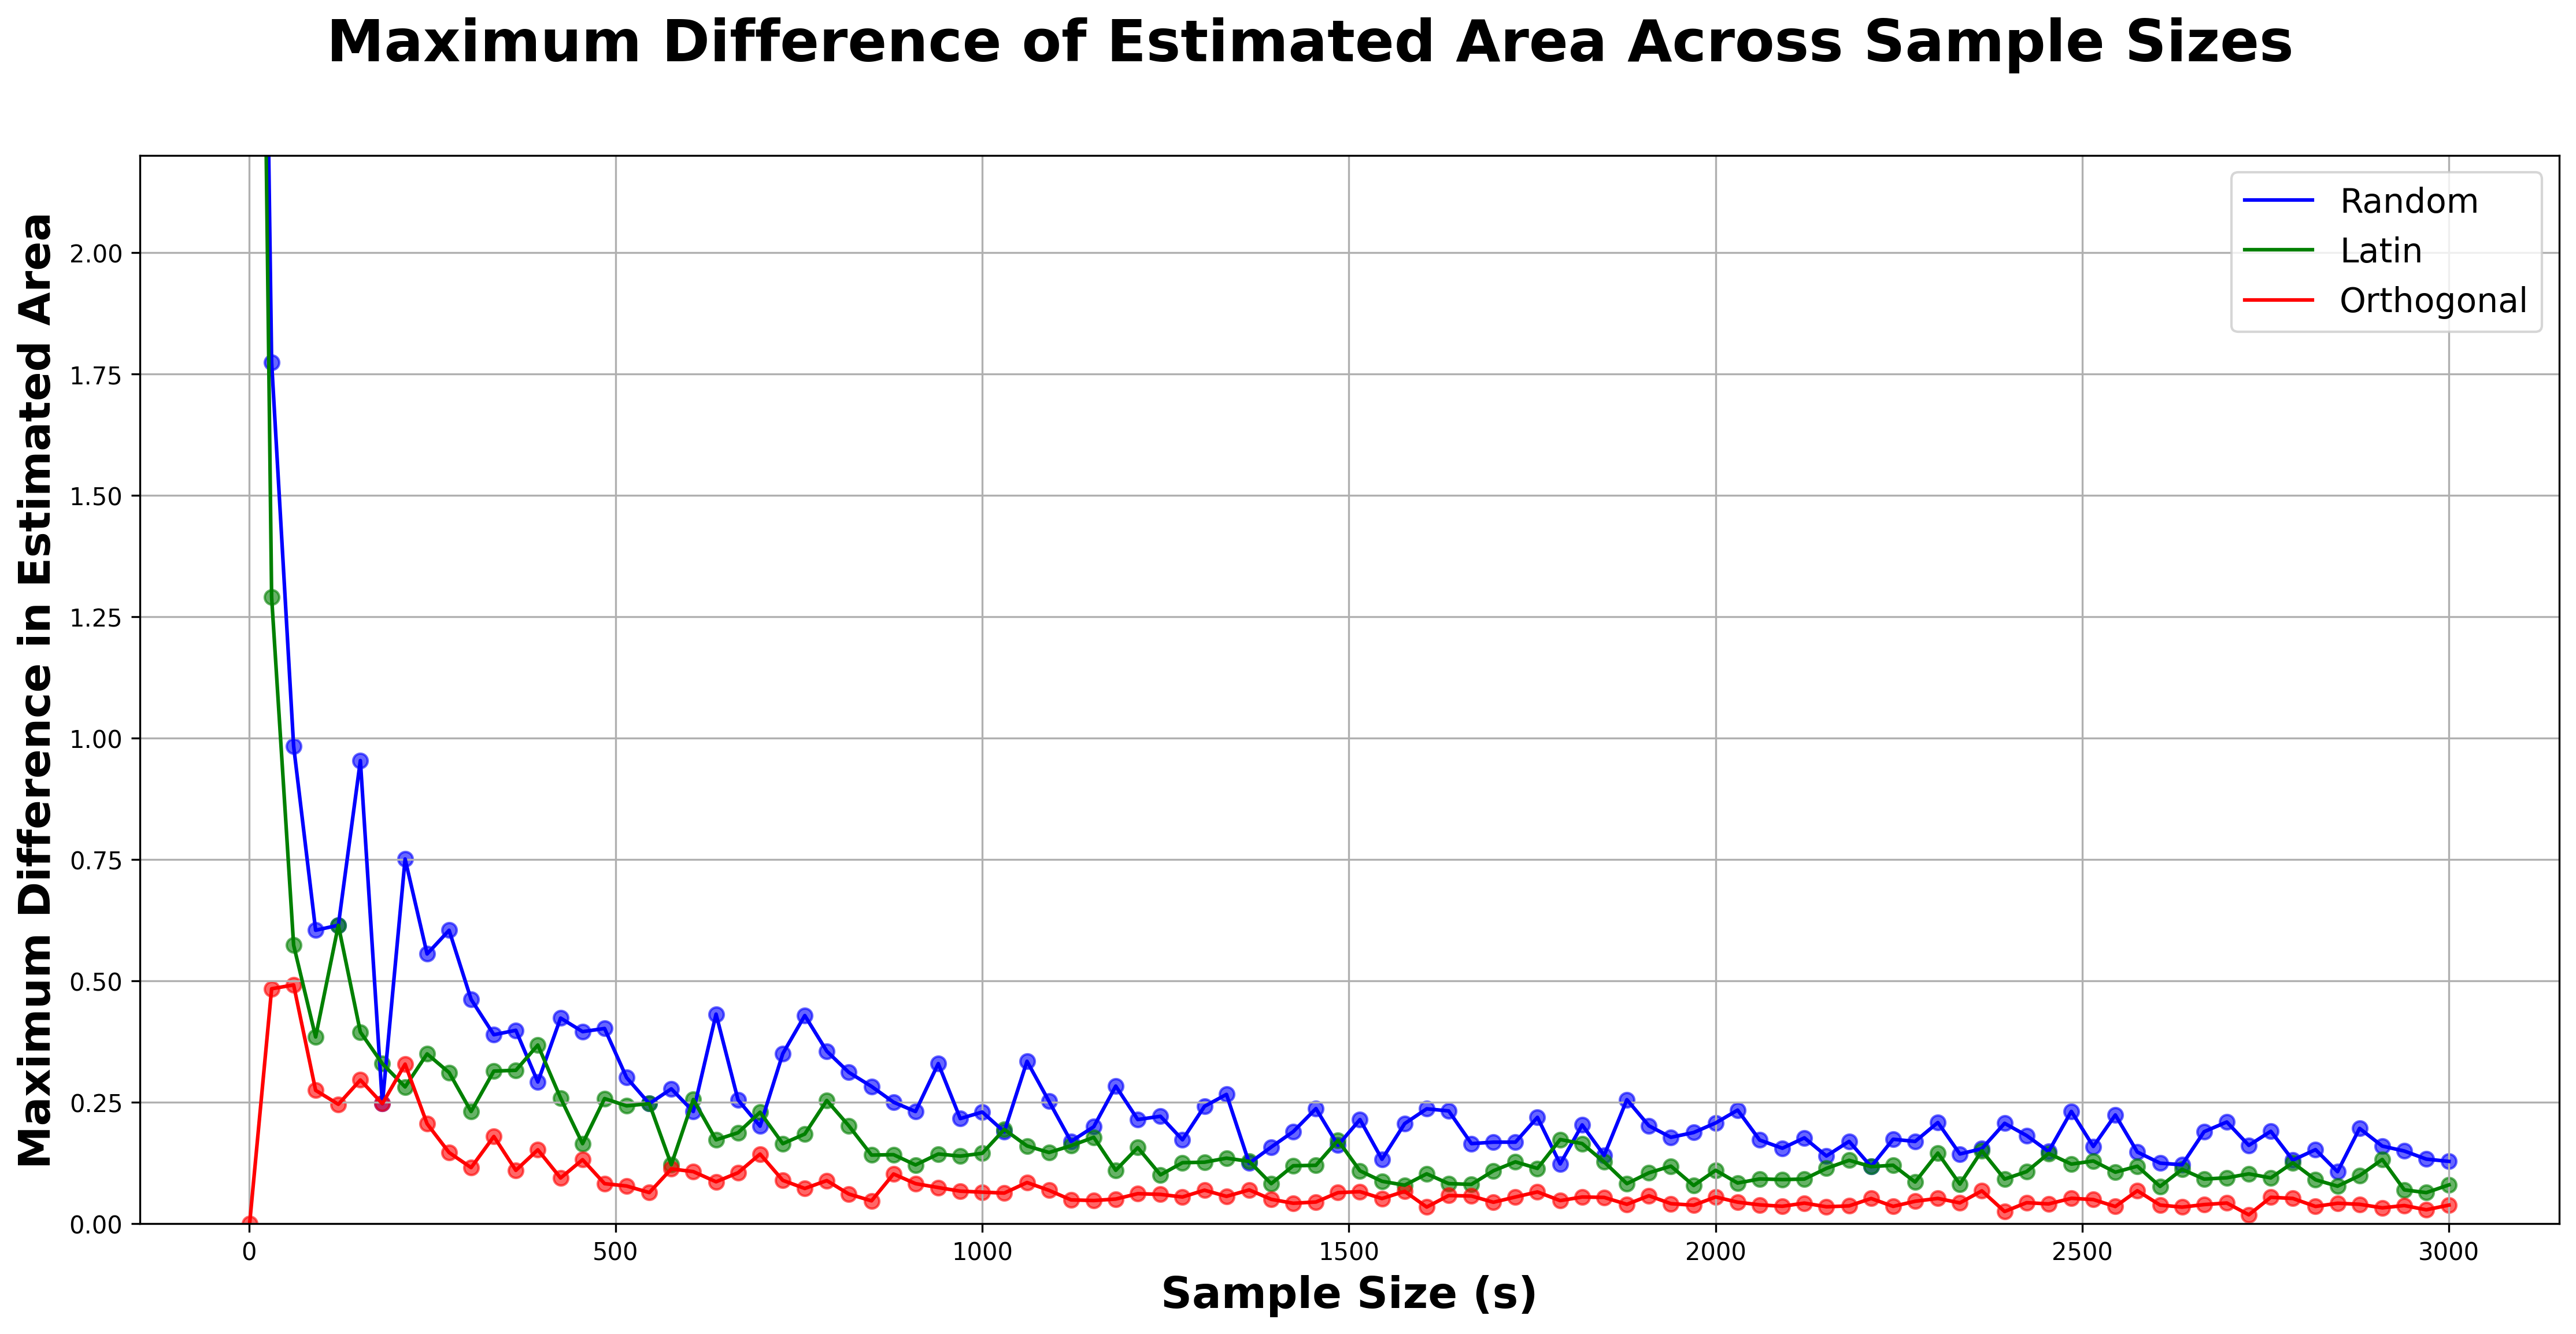

In [9]:
# This takes 1-5 min to compute so don't worry if it takes a while
# Define parameters
number_iterations = [1000] 
number_samples = np.linspace(1, 3000, 100, dtype=int)
number_runs = 15

# Function to get the areas from the simulation
def get_areas(method, samples):
    """calculate area of mandelbrot set for a given number of samples and a given method

    Args:
        method (string): type of sampling method
        samples (int): samples to take

    Returns:
        int: area of the mandelbrot set
    """
    _, _, areas = run_simulation(number_iterations, [samples], method, c_matrix, numberruns=number_runs)
    return areas

# Function to plot the maximum difference for a method
def plot_max_difference(method_name, color, ax):
    """plot the maximum difference for a method

    Args:
        method_name (string): method name of sampling method
        color (stirng): color for the plot
        ax (axes): axes to plot on
    """
    max_differences = []
    for samples in number_samples:
        # calculate the area then calcualte the difference between the highest and lowest value of the areas, then save that value
        areas = get_areas(method_name, samples)
        max_difference = max(areas) - min(areas)
        max_differences.append(max_difference)
    
    # Plot the data as a line then also as a scatter (line with dots at each point)
    ax.plot(number_samples, max_differences, color=color, label=method_name)
    ax.scatter(number_samples, max_differences, color=color, alpha=0.6) 

# Create a single plot with subplots for each sampling method
fig, ax = plt.subplots(dpi=300, figsize=(18, 8), sharey=True)
fig.suptitle('Maximum Difference of Estimated Area Across Sample Sizes', fontsize=24, fontweight="bold")

# Plot for each method
plot_max_difference("Random", 'blue', ax)
plot_max_difference("Latin", 'green', ax)
plot_max_difference("Orthogonal", 'red', ax)

ax.set_ylim(0,2.2)
ax.set_xlabel('Sample Size (s)', fontsize=18, fontweight='bold')
ax.set_ylabel('Maximum Difference in Estimated Area', fontsize=18, fontweight='bold')
ax.legend(loc='upper right', prop={"size":14})
plt.grid(True)
plt.show()


## <font color = LightCoral > **Statistical Analysis** </font>

### <font color = Gray> ***Confidence Interval, t-test, and Variance*** </font>

In [10]:
# Define i, s, and number of runs 
number_iterations = [1000]
number_samples = [100, 500, 1000, 3000, 5000]
sampling_method = ["Random", "Antithetic", "Latin", "Orthogonal"]
number_runs = 15


def statistical_analysis(sampling_method, number_samples, number_iterations, number_runs, c_matrix):
    """
    Analyses the Mandelbrot set area estimates using Monte Carlo simulations across
    different sampling methods and calculates statistical properties.

    Args:
        sampling_method (list): Sampling methods to be analyzed.
        number_samples (list): Sample sizes for simulations.
        number_iterations (list): Iteration counts for simulations.
        number_runs (int): Number of simulation runs.
        c_matrix (np.ndarray): Complex matrix for the Mandelbrot set.

    Returns:
        pd.DataFrame: Results including confidence intervals, t-test p-values, 
                      and variance ratios for each sampling strategy.
    """

    # Initialize dictionaries to store results
    area_results = {method: {} for method in sampling_method}
    ci_results = {method: [] for method in sampling_method}
    p_values = {}
    variance_ratios = {}
    
    for method in sampling_method:
        for iterations in number_iterations:
            for samples in number_samples:
                # Generate graphs and collect data
                _, data, area = run_simulation([iterations], [samples], method, c_matrix, numberruns=number_runs, printimage=False)
                
                # Extract standard deviation and mean
                stdev = [item[4] for item in data][-1]
                mean_area = [item[3] for item in data][-1]

                # Store areas in the dictionary
                if samples not in area_results[method]:
                    area_results[method][samples] = []
                area_results[method][samples].extend(area)

                # Calculate the confidence interval
                confidence_interval = stats.t.interval(0.95, len(area)-1, mean_area, stdev/math.sqrt(len(area)))
                ci_results[method].append(confidence_interval)

    # Perform t-tests for Random vs Latin and Random vs Orthogonal
    for samples in number_samples:
        t_stat, p_value = stats.ttest_ind(area_results['Random'][samples], area_results['Latin'][samples], equal_var=False)
        p_values[('Random', 'Latin', samples)] = p_value
        
        t_stat, p_value = stats.ttest_ind(area_results['Random'][samples], area_results['Orthogonal'][samples], equal_var=False)
        p_values[('Random', 'Orthogonal', samples)] = p_value

        # Calculate variance ratios for Random vs Antithetic
        if 'Antithetic' in sampling_method:
            var_random = variance(area_results['Random'][samples])
            var_antithetic = variance(area_results['Antithetic'][samples])
            variance_ratios[samples] = var_antithetic / var_random

    # Combine results into a DataFrame
    df = pd.DataFrame(index=number_samples)
    for method in sampling_method:
        df[f'CI: {method}'] = ci_results[method]
    for (method1, method2, samples), p_value in p_values.items():
        df.loc[samples, f'P-value: {method1} vs {method2}'] = p_value
    for samples, ratio in variance_ratios.items():
        df.loc[samples, 'Variance Ratio: Random vs Antithetic'] = ratio
    
    return df

df_results = statistical_analysis(sampling_method, number_samples, number_iterations, number_runs, c_matrix)
print(df_results)

print("Time taken: ", time.time() - time_start)

                                    CI: Random  \
100    (1.323263420976925, 1.5834032456897413)   
500   (1.4132258317987196, 1.5334408348679471)   
1000  (1.4780871974477352, 1.5592461358855985)   
3000  (1.4752017286384107, 1.5274649380282561)   
5000   (1.4765744759380723, 1.512225524061928)   

                                CI: Antithetic  \
100   (1.4073528262273842, 1.6126471737726162)   
500    (1.420490771038004, 1.5635092289619965)   
1000  (1.4674666262340925, 1.5385333737659068)   
3000   (1.4909731374071111, 1.548582418148445)   
5000   (1.495020415825084, 1.5251129175082494)   

                                     CI: Latin  \
100     (1.388976246262968, 1.511023753737032)   
500   (1.4899630149153813, 1.5367036517512864)   
1000  (1.4966312468296064, 1.5373687531703935)   
3000  (1.4931138454706052, 1.5288861545293946)   
5000  (1.4919420238301486, 1.5180579761698512)   

                                CI: Orthogonal  P-value: Random vs Latin  \
100   (1.463527777043